# 1. Load Data

In [1]:
#pip install prophet

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

from prophet import Prophet

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# скачиваем значения ключевой ставки с официального сайта ЦБ с 2013 по 2024 год
# ** Данные доступны с 17.09.2013 по 05.01.2024.**
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=05.01.2024'

data = requests.get(URL).text
beautiful_soup = BeautifulSoup(data, 'html.parser')
tables = beautiful_soup.find_all('table')
df = pd.read_html(str(tables))[0]
df.head()

,Дата,Ставка
0,05.01.2024,1600
1,04.01.2024,1600
2,03.01.2024,1600
3,29.12.2023,1600
4,28.12.2023,1600


In [4]:
df.iloc[:, 1:] /= 100

In [5]:
df.head()

,Дата,Ставка
0,05.01.2024,16.0
1,04.01.2024,16.0
2,03.01.2024,16.0
3,29.12.2023,16.0
4,28.12.2023,16.0


In [6]:
df.columns = ['datetime', 'keyrate']
df.head()

,datetime,keyrate
0,05.01.2024,16.0
1,04.01.2024,16.0
2,03.01.2024,16.0
3,29.12.2023,16.0
4,28.12.2023,16.0


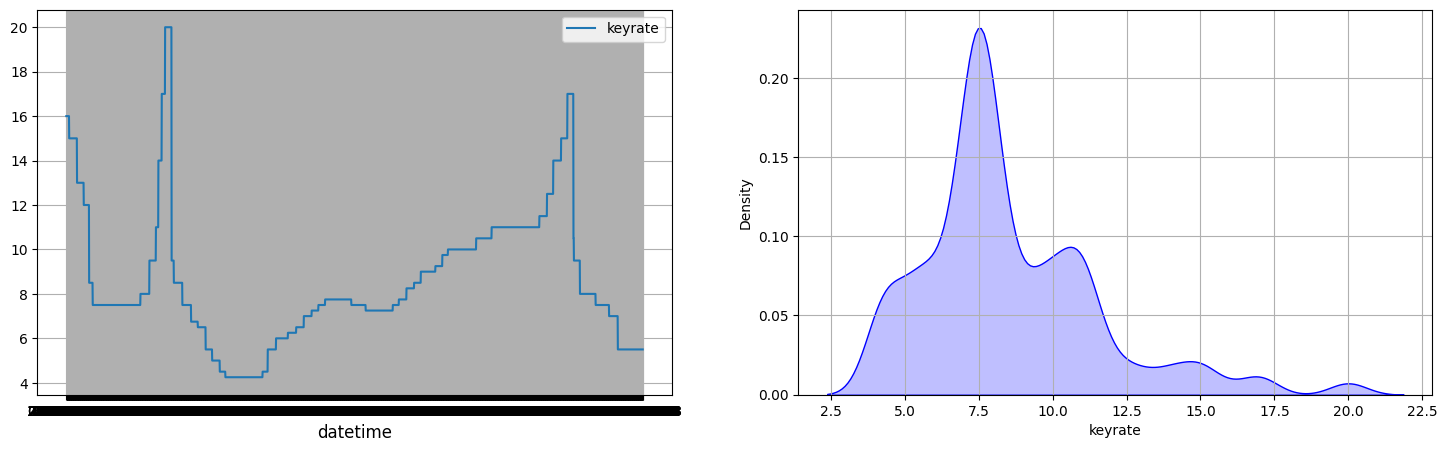

In [7]:
fig, axes = plt.subplots(1,2, figsize=(18, 5))

axes[0].plot(df.datetime, df.keyrate, label='keyrate')
axes[0].set_xlabel('datetime', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(ax=axes[1], data=df['keyrate'], color='blue', fill=True)
axes[1].grid(True)
plt.show()

# 2. Preprocessing

In [8]:
weekday_cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                                                'Saturday', 'Sunday'], ordered=True)

def create_features(data_full, col_datetime):
    """Creates time series features"""
    
    data = data_full.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(weekday_cat_type)
    data['quarter'] = data['datetime'].dt.quarter
    data['month'] = data[col_datetime].dt.month
    data['year'] = data[col_datetime].dt.year
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data[col_datetime].dt.day - 320) % 1300
    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])
    
    return data

In [9]:
df.head()

,datetime,keyrate
0,05.01.2024,16.0
1,04.01.2024,16.0
2,03.01.2024,16.0
3,29.12.2023,16.0
4,28.12.2023,16.0


In [10]:
# перевернем датасет так, чтобы он начинался с самой ранней даты
df = df[::-1].reset_index(drop=True)
df.head()

,datetime,keyrate
0,17.09.2013,5.5
1,18.09.2013,5.5
2,19.09.2013,5.5
3,20.09.2013,5.5
4,23.09.2013,5.5


In [11]:
df['datetime'] = pd.to_datetime(df['datetime'].astype(str), format='%d.%m.%Y')
df.head()

,datetime,keyrate
0,2013-09-17,5.5
1,2013-09-18,5.5
2,2013-09-19,5.5
3,2013-09-20,5.5
4,2013-09-23,5.5


In [12]:
df_with_features = create_features(data_full = df, col_datetime = 'datetime')
df_with_features.head()

,datetime,keyrate,weekday,quarter,month,year,date_offset,season
0,2013-09-17,5.5,Tuesday,3,9,2013,597,summer
1,2013-09-18,5.5,Wednesday,3,9,2013,598,summer
2,2013-09-19,5.5,Thursday,3,9,2013,599,summer
3,2013-09-20,5.5,Friday,3,9,2013,600,summer
4,2013-09-23,5.5,Monday,3,9,2013,603,autumn


In [13]:
year_Aggregated = pd.DataFrame(df_with_features.groupby('year')['keyrate'].max()).reset_index().sort_values('keyrate')
year_Aggregated.head()

,year,keyrate
0,2013,5.50
7,2020,6.25
5,2018,7.75
6,2019,7.75
8,2021,8.50


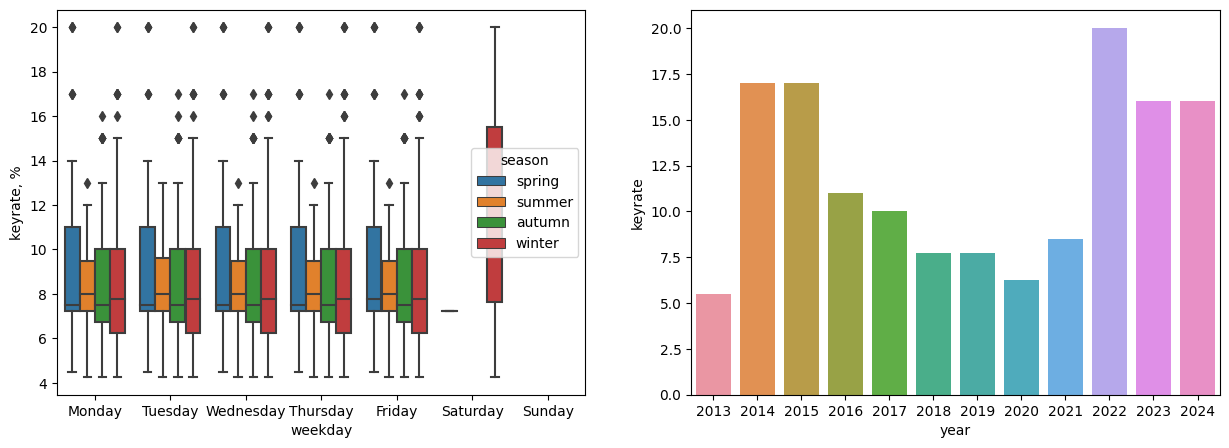

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(ax=axes[0], data=df_with_features, hue='season', x='weekday', y='keyrate')
axes[0].set_xlabel('weekday')
axes[0].set_ylabel('keyrate, %')

sns.barplot(ax=axes[1], data=year_Aggregated, x='year', y='keyrate')
plt.show()

Видим, что ключевая ставка обычно выше летом и ниже весной. Данных по ключевой ставке в воскресенье нет. Также стоит заметить выбросы в субботу. 

In [15]:
df_with_features[df_with_features.weekday == 'Saturday']

,datetime,keyrate,weekday,quarter,month,year,date_offset,season
601,2016-02-20,11.00,Saturday,1,2,2016,1200,winter
1141,2018-04-28,7.25,Saturday,2,4,2018,108,spring
1168,2018-06-09,7.25,Saturday,2,6,2018,289,spring
1844,2021-02-20,4.25,Saturday,1,2,2021,1200,winter
2108,2022-03-05,20.00,Saturday,1,3,2022,1285,winter


Действительно, в 2022 году ставка достигла 20-ти процентов. Посмотрим, есть ли еще строки с такой ставкой.

In [16]:
df_with_features[464:474]

,datetime,keyrate,weekday,quarter,month,year,date_offset,season
464,2015-08-05,11.0,Wednesday,3,8,2015,485,summer
465,2015-08-06,11.0,Thursday,3,8,2015,486,summer
466,2015-08-07,11.0,Friday,3,8,2015,487,summer
467,2015-08-10,11.0,Monday,3,8,2015,490,summer
468,2015-08-11,11.0,Tuesday,3,8,2015,491,summer
469,2015-08-12,11.0,Wednesday,3,8,2015,492,summer
470,2015-08-13,11.0,Thursday,3,8,2015,493,summer
471,2015-08-14,11.0,Friday,3,8,2015,494,summer
472,2015-08-17,11.0,Monday,3,8,2015,497,summer
473,2015-08-18,11.0,Tuesday,3,8,2015,498,summer


Удалим экстремальные значения в 20% из исходного датасета, чтобы они не влияли на формирование трендов в зависимости от дней недели, сезонов и т.д.

In [17]:
idx_to_drop = df_with_features[df_with_features['keyrate'] == 20].index
df = df.drop(idx_to_drop)
df = df.reset_index(drop=True)

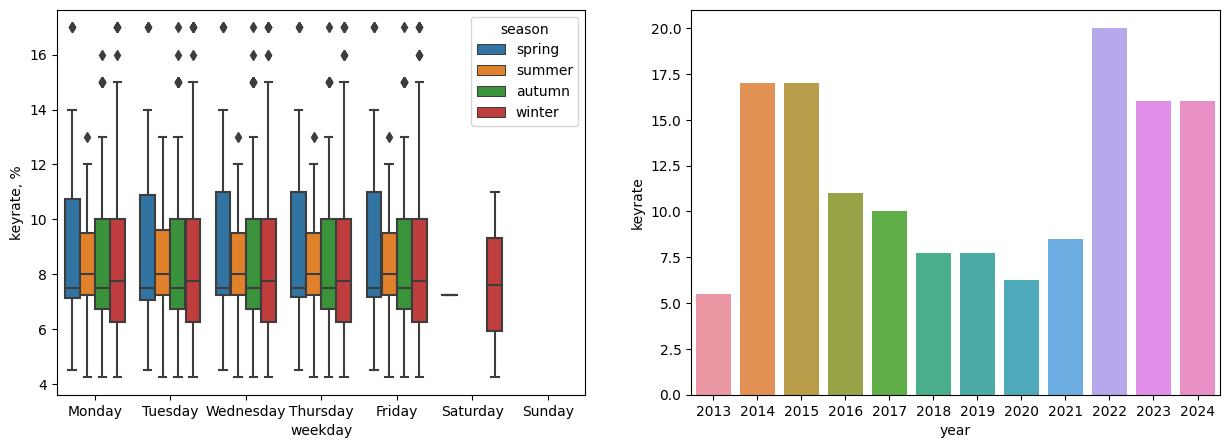

In [18]:
df_with_features_dropped = df_with_features.drop(idx_to_drop)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(ax=axes[0], data=df_with_features_dropped, hue='season', x='weekday', y='keyrate')
axes[0].set_xlabel('weekday')
axes[0].set_ylabel('keyrate, %')

sns.barplot(ax=axes[1], data=year_Aggregated, x='year', y='keyrate')
plt.show()

# 3. Prophet Model

В качестве тестовой выборки возьмем последние 10% из исходного датасета. Остальное - обучающая выборка.

Входными данными всегда является датафрейм с двумя столбцами- ds и y.

In [19]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2013-09-17,5.5
1,2013-09-18,5.5
2,2013-09-19,5.5
3,2013-09-20,5.5
4,2013-09-23,5.5


In [20]:
TEST_SIZE = int(df.shape[0] * 0.1)
TEST_SIZE

254

In [21]:
train_df = df[:-TEST_SIZE]
test_df = df[-TEST_SIZE:]
train_df.shape, test_df.shape

((2290, 2), (254, 2))

In [22]:
train_df['ds'][-1:]

2289   2023-01-05
Name: ds, dtype: datetime64[ns]

Попробуем визуализировать наши данные:

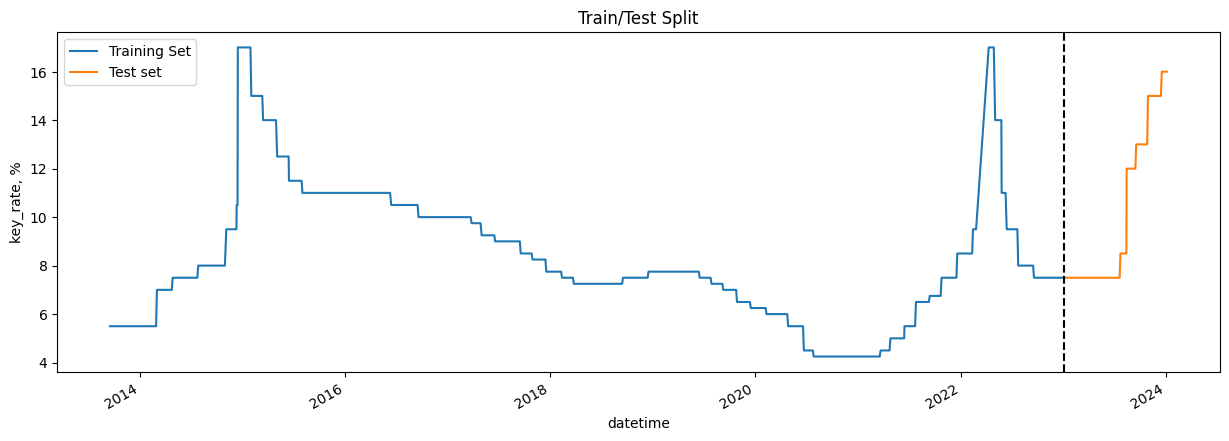

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
train_df.set_index('ds').plot(ax=ax,
                             label='Train',
                             title='Train/Test Split')
test_df.set_index('ds').plot(ax=ax,
                            label='Test')
ax.axvline(train_df['ds'][-1:].values, color='black', ls='--')
ax.legend(['Training Set', 'Test set'])
ax.set_ylabel('key_rate, %')
ax.set_xlabel('datetime')
plt.show()

## Baseline Prophet Model

In [24]:
%%time
model_0 = Prophet()
model_0.fit(train_df)

08:43:11 - cmdstanpy - INFO - Chain [1] start processing
08:43:11 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 1.5 s


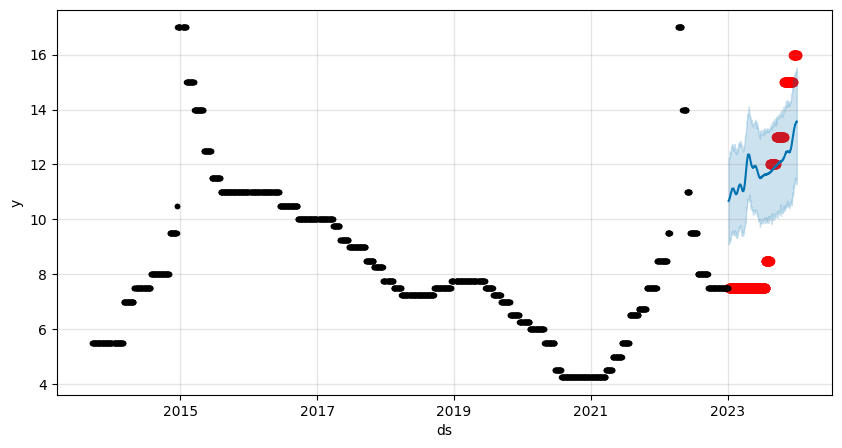

In [25]:
preds_0 = model_0.predict(test_df)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(test_df['ds'], test_df['y'], color='r')
fig = model_0.plot(preds_0, ax=ax)
plt.show()

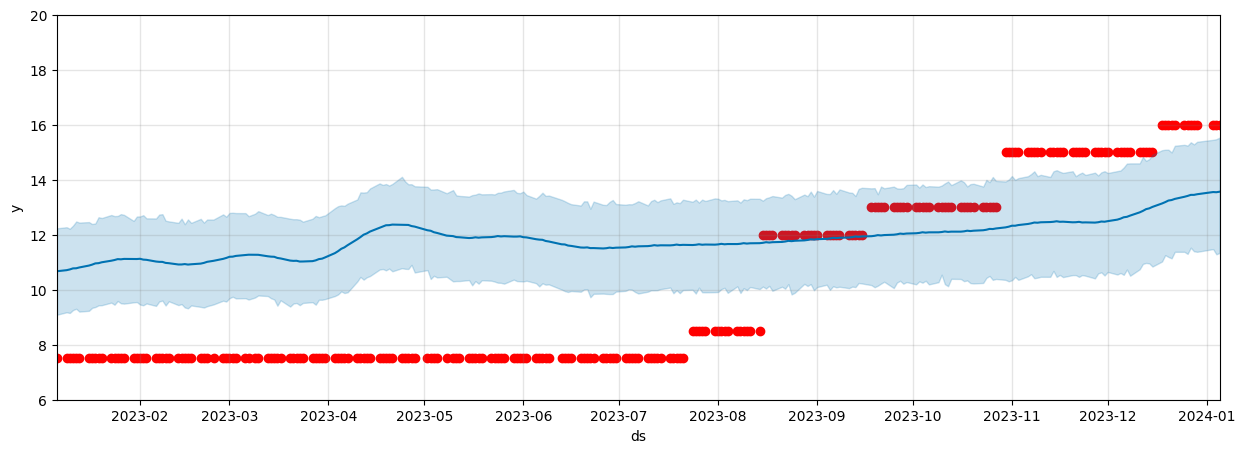

In [26]:
# приблизим график в области предсказаний
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(test_df['ds'], test_df['y'], color='r')

fig = model_0.plot(preds_0, ax=ax)

ax.set_xbound(lower=test_df['ds'][:1].values,
             upper=test_df['ds'][-1:].values)
ax.set_ylim(6,20)
plt.show()

Видим, что модель не смогла предсказать в начале сильное снижение ставки.

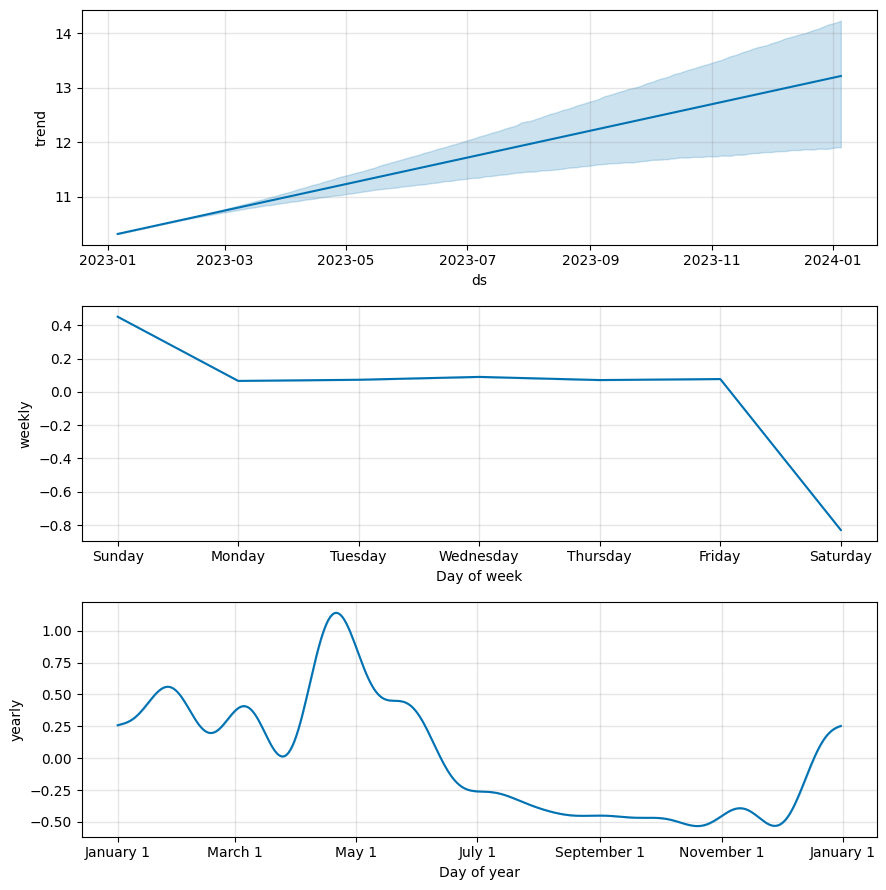

In [27]:
# разложение на компоненты
fig = model_0.plot_components(preds_0)
plt.show()

## Evaluate The Baseline Model

В качестве метрики возьмем MAE, поскольку распределение данных ненормальное.

In [28]:
# датасет для итогового предсказания
test_df_null = test_df.copy()
test_df_null['y'] = None

df_for_pred = pd.concat([train_df, test_df_null])
preds = model_0.predict(df_for_pred)
preds.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-09-17,4.552515,2.750942,5.789476,4.552515,4.552515,-0.392320,-0.392320,-0.392320,0.073065,0.073065,0.073065,-0.465385,-0.465385,-0.465385,0.0,0.0,0.0,4.160195
1,2013-09-18,4.563366,2.620093,5.690645,4.563366,4.563366,-0.375833,-0.375833,-0.375833,0.090263,0.090263,0.090263,-0.466096,-0.466096,-0.466096,0.0,0.0,0.0,4.187533
2,2013-09-19,4.574218,2.532761,5.670459,4.574218,4.574218,-0.395315,-0.395315,-0.395315,0.071317,0.071317,0.071317,-0.466632,-0.466632,-0.466632,0.0,0.0,0.0,4.178903
3,2013-09-20,4.585069,2.693396,5.755567,4.585069,4.585069,-0.389657,-0.389657,-0.389657,0.077337,0.077337,0.077337,-0.466995,-0.466995,-0.466995,0.0,0.0,0.0,4.195412
4,2013-09-23,4.617623,2.664347,5.789489,4.617623,4.617623,-0.401087,-0.401087,-0.401087,0.066141,0.066141,0.066141,-0.467228,-0.467228,-0.467228,0.0,0.0,0.0,4.216536


In [29]:
mean_absolute_error(y_true=test_df['y'],
                   y_pred=preds['yhat'][train_df.shape[0]:])

2.9314992401928284

In [30]:
mean_absolute_percentage_error(y_true=test_df['y'],
                   y_pred=preds['yhat'][train_df.shape[0]:])

0.34857589124681215

# 5. Predict Into The Future (2024)

Теперь на вход модели подадим полный датасет

In [31]:
%%time
full_model = Prophet()
full_model.fit(df)

08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:14 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 664 ms


Попытаемся предсказать ключевую ставку на 200 дней вперед

In [32]:
future = full_model.make_future_dataframe(periods=200, freq='D')
forecast = full_model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-09-17,3.920778,1.726662,5.645587,3.920778,3.920778,-0.218392,-0.218392,-0.218392,-0.024198,-0.024198,-0.024198,-0.194194,-0.194194,-0.194194,0.0,0.0,0.0,3.702386
1,2013-09-18,3.937106,1.945004,5.635072,3.937106,3.937106,-0.187335,-0.187335,-0.187335,0.001005,0.001005,0.001005,-0.188340,-0.188340,-0.188340,0.0,0.0,0.0,3.749771
2,2013-09-19,3.953435,1.789157,5.640310,3.953435,3.953435,-0.198139,-0.198139,-0.198139,-0.016019,-0.016019,-0.016019,-0.182120,-0.182120,-0.182120,0.0,0.0,0.0,3.755295
3,2013-09-20,3.969763,1.781403,5.732519,3.969763,3.969763,-0.200607,-0.200607,-0.200607,-0.024963,-0.024963,-0.024963,-0.175643,-0.175643,-0.175643,0.0,0.0,0.0,3.769157
4,2013-09-23,4.018748,1.885056,5.725936,4.018748,4.018748,-0.198588,-0.198588,-0.198588,-0.042577,-0.042577,-0.042577,-0.156011,-0.156011,-0.156011,0.0,0.0,0.0,3.820160


Визуализируем полученные предсказания:

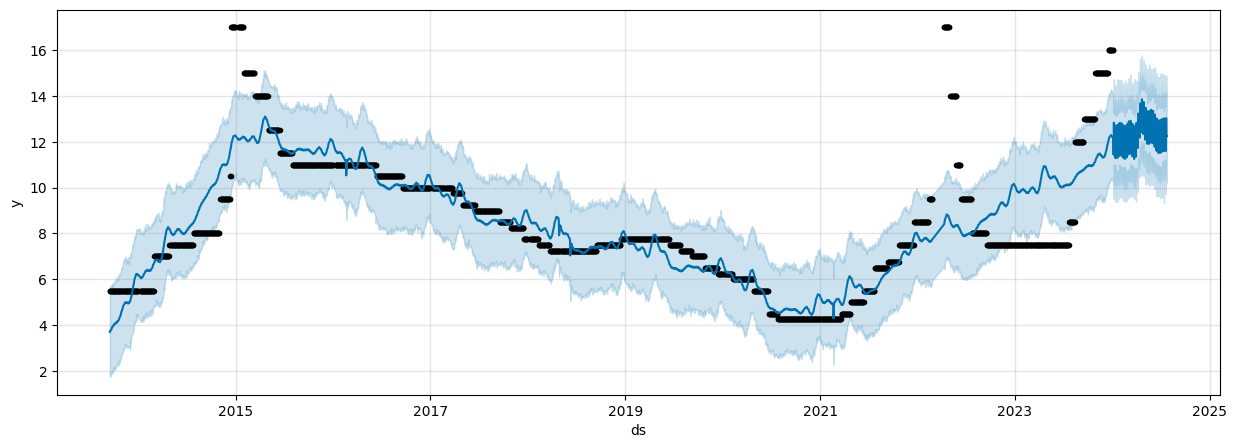

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
fig = full_model.plot(forecast, ax=ax)

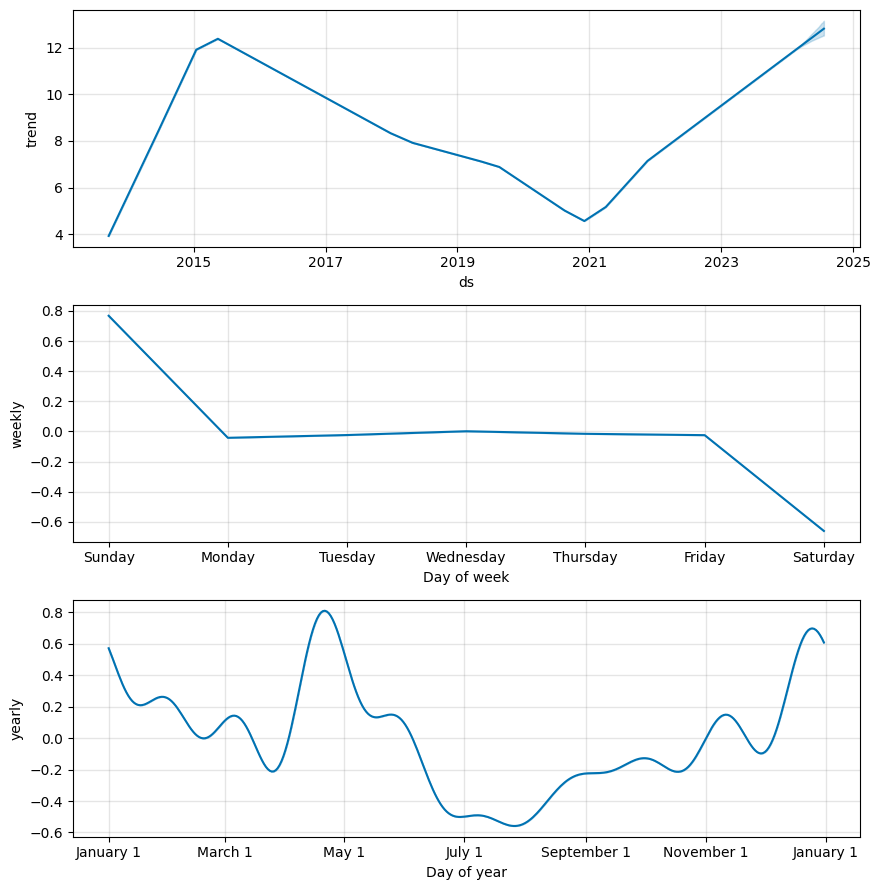

In [34]:
fig = full_model.plot_components(forecast)
plt.show()

Если взглянуть на графики компонентов, то можно сказать, что ключевая ставка имеет тренд расти и дальше. 
Возможно, будет небольшой спад в начале этого года.
Но нужно заметить, что наша модель не учитывала резкие скачки в исторических данных, поэтому навряд ли она способна предсказать "всплески".